# CIS-522 Week 6 Homework

__Instructor__: Konrad Kording

__Content creators:__ Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

__Content reviewers:__ Ann-Katrin Reuel


In this homework, you will implement image classification problem on a much more complex Dataset, the **CIFAR 10 Dataset**. We will train two models a fully connected network and a Convolutional Neural Network and observe the differences in their performance on images. Further, we will also try to visualize the features learn by some of our Convolutional layers in CNN and answer some questions about ethics and our pod members!

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}


# start timing
import time
try:t0;
except NameError: t0 = time.time()


In [2]:
# @title Run this cell for imports.

# imports
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep

In [3]:
# @markdown Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


In [4]:
#@markdown Device Settings<br> It should print 'cuda', if not change your runtime to GPU.
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Part 0. Exploring the Dataset and Basic Functions





The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes in the dataset are:<br>
['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let us download the dataset, and build our datatloaders. Set the **BATCH_SIZE** for the dataloaders yourself. 

The three dataloaders are accessible by the variables *trainloader*, *validationloader* and *testloader*. 

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# TODO: set Batch size for dataloaders
BATCH_SIZE = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# splitting the testset into testset and validationset, with a 80:20 ratio
validationset, testset = torch.utils.data.random_split(testset, [8000, 2000])

validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us check the sizes of our three sets and print some images. 

In [6]:
print(len(trainset))
print(len(validationset))
print(len(testset))

50000
8000
2000


torch.Size([100, 3, 32, 32])


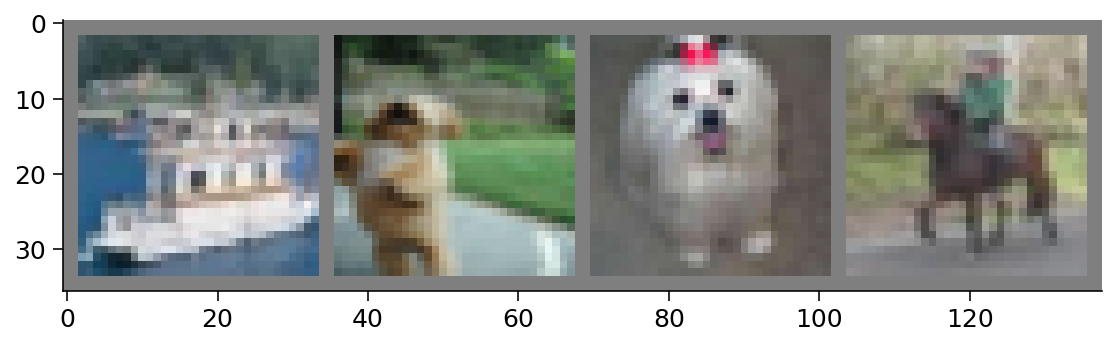

 ship    		  dog    		  dog    		horse


In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

imshow(torchvision.utils.make_grid(images[0:4]))
print('    \t\t'.join('%5s' % classes[labels[j]] for j in range(4)))

Now let us write a train function which basically trains any network by running epochs and also evaluates the results on our validation set in every epoch. We will keep tunable hyperparameters as the parameters for the function, so that we can directly tweak them and call the function. 

In [8]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
  # Params:
  #   model-> instance of your model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   train_loader -> dataloader for train dataset, already stored in a variable called *trainloader*
  #   validation_loader -> dataloader for validation dataset, already stored in a variable called *validationloader*
  #   epochs -> number of epochs for training, you are expected to experiment and play around with this
  #   criterion -> the loss function which you decide to use
  #   optimizer -> optimizer for your gradient descent, do not forget to set an appropriate learning rate
  #  Returns:  train_loss, train_accuracy, validation_loss, validation_accuracy, all of these are lists storing the values 

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        # TODO: train on the train dataset
        # adapted from CIS 522 tutorial code
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
            

                
        # TODO: evaluate on validation data
        # adapted from CIS 522 tutorial code
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    
    return train_loss, train_acc, validation_loss, validation_acc 

Now, let us write a test function, which returns the accuracy of a trained model on the testdataset, given the testloader. 


In [9]:
def test(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   accuracy(float)-> percentage of correct predictions made by your trained model
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
      # TODO: fill in the test function
      # adapted from CIS 522 tutorial code
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total

    return acc

Below, we have provided a function to plot your train loss, test loss, train accuracy and test accuracy, during the training process. They take in arguments, which were the four lists returned by your train function. 

In [10]:
# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


# Part 1: FeedForward Neural Network

In this section, we will implement a Feed forward Neural Network that can classify the images in the CIFAR 10 dataset. 

Here, we define our FFN class which will consists of all the layers and the forward function. Feel free to play around by introducing different types of regularization, architectures, learning rates, epochs, and batch sizes, in order to achieve maximum accuracy, except the constraint that do not use convolutional layers in the model. 

## Architecture

In [11]:
class FFN(nn.Module):
    def __init__(self, input_size=3 * 32 * 32, num_classes=10):
        super().__init__()

        hidden = 62
        layers = 2
        self.model = None 

        ########################################################################
        # TODO: Initialize your model!                                         #
        ########################################################################
        
        modules = [nn.Linear(input_size, hidden), nn.ReLU(), nn.Dropout()]
        for n in range(int(layers)):
            modules.append(nn.Linear(hidden, hidden))
            modules.append(nn.Linear(hidden, hidden))
            modules.append(nn.BatchNorm1d(62))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout())
        modules.append(nn.Linear(hidden, num_classes))
        
        self.model = nn.Sequential(*modules)

  # TODO: define the forward pass
    def forward(self, x):
      x = x.view(x.shape[0], -1)
      x = self.model(x)
      return x



## Training

Now, let us intantiate our FFN class, define the loss, the optimizer and call the train function. 

In [ ]:
# TODO: set criterion, optimizer and other hyperparameters and train
net1 = FFN().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net1.parameters(), lr=learning_rate)
num_epochs = 60
train_loss, train_acc, validation_loss, validation_acc = train(net1, device, trainloader, validationloader, num_epochs, criterion, optimizer)

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/80 [00:00<?, ?batch/s]

## Training Plots

Now, let us plot the train and validation curves. 

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Take a screenshot of your Training Curves (Both Accuracy and Loss) and submit it in the AirTable Form at the end of the Worksheet.

## Test Accuracy

And test our trained network on the test set. 

In [ ]:
test(net1, device, testloader)

And fill up the accuracy value you get. 

In [ ]:
ffn_accuracy = test(net1, device, testloader)

Try to reach a test accuracy of atleast 45% with the Fully Connected Network. Try for even more!

You may try different models and variations and then submit the results (training curves) and the accuracy of your best model.

## Discuss



In [ ]:
#@markdown Now, discuss the hyperparameters and architectures you chose. Which model led to the best performance? Why? (200 words)
import time
try:t1;
except NameError: t1 = time.time()

In [ ]:
ffn_discussion = ''' 
One thing that helped me was increasing the number of epochs. I initially started with 10 but saw from the graphs that there was still an upward trend. I further realized that I had to include BatchNorm1d, ReLU and Dropout layers on top of two Linear layers to get close to the desired accuracy. Especially the Dropout layer made – architecture-wise – a big difference. Dropout layers generally help the model to get a fresh view on the data and discover new patterns because it's forced to deviate from using the nodes that it did thus far. I further found out that an increased number of layer packages doesn't necessarily increase performance. For example, 4 layer packages gave me a worse performance than 3, which indicates that more complex isn't always better.
'''

# Part 2: Convolutional Neural Network

Now, design a Convolutional Neural Network, for the same problem. Again, try to play around with various architectures, regularizations, activations, learning rates, optmizers and try to leverage the power of CNNs!

**Note:** Put all your Convolutional layers, activations in the first Sequential module, instead of defninig different layers and making an explicit forward pass.
Similarly, add all the subsequent fully connected layers in the second Sequential module, which comes after flattening the output from the convolutional layers.

**Do not change the forward pass code here.** 
<br>
This will help you run the next section on Visualization on your chosen architecture and visualize the feature maps of different convolutional layers. 

## Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(
            self,
            batch_size = 10,
            learning_rate = 1e-4,
            num_classes = 10):
        super().__init__()

        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc1 = nn.Linear(2048, num_classes)
        

    def forward(self, x):

        # feed x into model!
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        return x


## Training

Calling the train function for the ConvNet.

In [ ]:
# TODO: fill the hyperparameters and train the model
net2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net2.parameters(), lr=learning_rate)
num_epochs = 10
train_loss, train_acc, validation_loss, validation_acc = train(net2, device, trainloader, validationloader, num_epochs, criterion, optimizer)

## Training Plots

Now plot your training curves!

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## Test Accuracy

And, test your trained model on the Test Dataset. 

In [ ]:
test(net2, device, testloader)

And, fill up the accuracy here.

In [ ]:
cnn_accuracy = test(net2, device, testloader)

Try to reach an accuracy of atleast 52%.Of course try to get your test accuracy even higher, and leverage the true powers of CNNs!

## Discussion

In [ ]:
#@markdown Discuss the hyperparameters and architectures you chose. Which model led to the best performance? Did your CNN outperform your FFN? Why? (200 words)
import time
try:t2;
except NameError: t2 = time.time()

In [ ]:
cnn_discussion = '''
My first CNN architecture actually only achieved an accuracy of 17 % because I forgot to include a fully connected layer. This showed me the importance of the latter. When I included a fully-connected layer, my accuracy jumped to over 50 % on the first trial. My initial architecture just included two Conv2d layers and ReLU layers. However, including 
'''

# Part 4: Deep Learning, Deep Thinking


Okay, so you all just solved a classification task using the CIFAR Dataset. Before we move ahead, please read the following to articles. 
 https://excavating.ai/ and https://medium.com/analytics-vidhya/an-introduction-to-fairness-in-machine-learning-62ef827e0020 (explains the fundamentals of measuring fairness in machine learning models).
 
 
<br><br> 
What do these readings suggest? There may be problems with unbalanced data and biases present in data. Now, go back and reflect on what you just did. Did you consider these problems when you designed your convnet? Write your thoughts (about 100 words).

In [ ]:
bias_response = '''
These readings suggest that deep learning models are highly dependent on the data they are trained on in multiple ways: Firstly, on the class level. The choice of classes can be inherently biased and negatively impact the ethical and fairness metric of our model. Secondly, at the level of the individual image. Due to biased labelling in the underlying dataset, bias might also be introduced in our model. Thirdly, on the distribution of the data to the different classes. We've seen in past assignments that if one class is overrepresented, the classification algorithm is more likely to pick that class if it is unsure. To be honest, I didn't consider these aspects when coding my networks. Given that I'm not the strongest coder, I tend to spend quite some time getting to run things, and ethical aspects get left behind. I really appreciate that this course has been so adament on the ethical implications and what we can do as coders. If I'd have to tackle the assignment again, I would first start with investigating the underlying dataset. This could include a random check of images and labels as well as checking out research and critiques about the dataset. In addition, I'd implement per-class accuracy and false negative/false positive measures in the code and make sure that the algorithm only returns results that satisfy certain independence and separation criteria threshholds.
'''

Now, its time to see what those implications are on the models you just trained. <br>

<br>



> Report the results of the independence and separation criteria you just read about in the medium article i.e report the accuracy for each class (independence) and report the false positive and false negative for each class (separation). <br>You can write separate code for implementing this. 
<br>



In [ ]:
independence_accuracy = ...
false_pos = ...
false_neg = ...




# Part 5: Better Know Your Pod

In [ ]:
#@markdown Write about the heroes or rolemodels of two of your pod members. Why did they choose them? Which accomplishments or traits do they admire about them? (~100 words each)
import time
try:t4;
except NameError: t4 = time.time()

In [ ]:
know_your_pod_1 = ''

In [ ]:
know_your_pod_2 = ''

# Submit your responses
Please run the following cell and then press "Submit" so we can record your responses.

In [ ]:

#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers, upload your screenshots, paste the notebook link and then click "Submit". If you have any issues, submit your answers manually here: https://airtable.com/shrTQeQ67ZsllnT39

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
from urllib.parse import quote_plus

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, quote_plus(fields[key]) if isinstance(fields[key], str) else fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_email;
except NameError: my_email = ""

try: my_pod;
except NameError: my_pod = "Select"

try: ffn_accuracy;
except NameError: ffn_accuracy = ""

try: ffn_discussion;
except NameError: ffn_discussion = ""

try: cnn_accuracy;
except NameError: cnn_accuracy = ""

try: cnn_discussion;
except NameError: cnn_discussion = ""

try: know_your_pod_1;
except NameError: know_your_pod_1 = ""

try: know_your_pod_2;
except NameError: know_your_pod_2 = ""

try: bias_response;
except NameError: bias_response = ""

times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "email": my_email,
          "ffn_accuracy":ffn_accuracy,
          "ffn_discussion": ffn_discussion,
          "cnn_accuracy": cnn_accuracy,
          "cnn_discussion": cnn_discussion,
          "know_your_pod_1":know_your_pod_1,
          "know_your_pod_2":know_your_pod_2,
          "bias_response":bias_response,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrTQeQ67ZsllnT39?"
#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))